In [1]:
from keras import backend as K
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from Image_Generator import TextImageGenerator
from Model import get_Model
from parameter import *
K.set_learning_phase(0)

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.__version__
tf.debugging.set_log_device_placement(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16974245698991334156
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6620742943
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3659067603066773939
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
model = get_Model(training=True)

try:
    model.load_weights('LSTM+BN5--10--0.718.hdf5')
    #model.load_weights('LSTM+BN5--25--0.402.hdf5')
    #print("...Previous weight data...")
    print("skip")
except:
    print("...New weight data...")
    pass

train_file_path = './DB/train/'
tiger_train = TextImageGenerator(train_file_path, img_w, img_h, batch_size, downsample_factor)
tiger_train.build_data()

valid_file_path = './DB/test/'
tiger_val = TextImageGenerator(valid_file_path, img_w, img_h, val_batch_size, downsample_factor)
tiger_val.build_data()









Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
skip
129946  Image Loading start...
True
129946  Image Loading finish...
25996  Image Loading start...
True
25996  Image Loading finish...


In [5]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)



1 Physical GPUs, 1 Logical GPUs


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [6]:

ada = Adadelta()

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=4, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath='LSTM+BN5--{epoch:02d}--{val_loss:.3f}.hdf5', monitor='loss', verbose=1, mode='min', period=1)
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=ada)

# captures output of softmax so we can decode the output during visualization
hist = model.fit_generator(generator=tiger_train.next_batch(),
                    steps_per_epoch=int(tiger_train.n / batch_size),
                    epochs=30,
                    callbacks=[checkpoint],
                    validation_data=tiger_val.next_batch(),
                    validation_steps=int(tiger_val.n / val_batch_size))

print(hist.history['loss'])
print(hist.history['acc'])
print(hist.history['val_loss'])
print(hist.history['val_acc'])

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


Epoch 1/30
1014/1015 [============================>.] - ETA: 0s - loss: 7.2692
Epoch 00001: saving model to LSTM+BN5--01--5.882.hdf5
1015/1015 [==============================] - 413s 407ms/step - loss: 7.2638 - val_loss: 5.8817
Epoch 2/30
1014/1015 [============================>.] - ETA: 0s - loss: 2.0221
Epoch 00002: saving model to LSTM+BN5--02--1.084.hdf5
1015/1015 [==============================] - 400s 394ms/step - loss: 2.0214 - val_loss: 1.0840
Epoch 3/30
1014/1015 [============================>.] - ETA: 0s - loss: 0.8074
Epoch 00003: saving model to LSTM+BN5--03--0.453.hdf5
1015/1015 [==============================] - 397s 391ms/step - loss: 0.8070 - val_loss: 0.4525
Epoch 4/30
1014/1015 [============================>.] - ETA: 0s - loss: 0.4806
Epoch 00004: saving model to LSTM+BN5--04--0.284.hdf5
1015/1015 [==============================] - 400s 394ms/step - loss: 0.4804 - val_loss: 0.2840
Epoch 5/30
1014/1015 [============================>.] - ETA: 0s - loss: 0.2508
Epoch 00

KeyError: 'acc'

KeyError: 'acc'

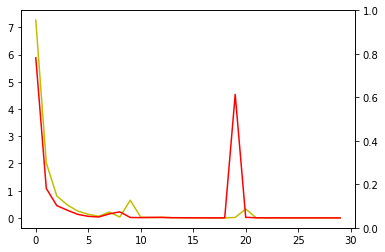

In [8]:
#print(hist.history['loss'])
#print(hist.history['acc'])
#print(hist.history['val_loss'])
#print(hist.history['val_acc'])

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')



In [ ]:
!python Prediction.py -w "LSTM+BN5--30--0.001.hdf5" -t "./DB/real_test/"

In [ ]:
!python Prediction.py -w "LSTM+BN5--29--0.250.hdf5" -t "./DB/test/"

In [ ]:
!python Prediction.py -w "LSTM+BN5--15--0.951.hdf5" -t "./DB/real_test/"

In [ ]:
!python Prediction.py -w "LSTM+BN5--50--0.889.hdf5" -t "./DB/real_test/"